$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 2: Ridge Regression with K-Fold Cross-Validation

Yashad Samant

## Overview


In this assignment, we have implemented ridge regression rather than linear regression, along with K-fold Cross-Validation. Ridge regression is nothing but a modified version linear regression where we add an extra parameter lambda in the train function. When lambda is 0, it is nothing but linear regression. While we have calculated root mean square error for each lambda, we have repeated it multiple times to reduce the error. The higher the folds, the lesser will be the error. Now what we are interested in is the minimal error and we have found the corresponding less error for each and every fold and stored in single array result_final. When we observe this array, we find that we find the lowest error for lambda equal to 0.         




## Method

1. import libraries
2. Defining train, use and rmse function. 
    a. Train fuction is modified, extra parameter lambda is added. We use lambda to calculate weights, when its 0, weights are          equivalent to one in linear regression method.
    b. Use function is same as one used in linear regression and so is rmse.
3. We have defined a K-fold function which calculates the error multiple times with multiple lambdas and this is repeated for      folds * folds-1 times. The larger the number of folds, lesser is the error. For each fold, we have divided data into train,      test and validate and all three are different for different folds.
4. Lastly, we have multiple lambdas function where we have calculated rmses for test, train and validate sets for different        folds and saved it in a single array. But our objective is to find the minimum error and also find the corresponding lambda.    We find it using the min function and store it in a different array and return it to main program.   

In [1]:
#Libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Train, Use & Rmse functions
def train(X,T,lamb):
    means = X.mean(0)
    stds = X.std(0)
    n,d = X.shape
    Xs1 = np.insert( (X - means)/stds, 0, 1, axis=1)
    lambDiag = np.eye(d+1) * lamb
    lambDiag[0,0] = 0
    w = np.linalg.lstsq( Xs1.T.dot(Xs1) + lambDiag, Xs1.T.dot(T))[0]
    return {'w': w, 'means':means, 'stds':stds}

def use(X,model):
    Xs1 = np.insert((X-model['means'])/model['stds'], 0, 1, axis=1)
    return Xs1.dot(model['w'])

def rmse(A,B):
    return np.sqrt(np.mean( (A-B)**2 ))

In [3]:
# K-Fold Cross-Validation
def partitionKFolds(X,T,nFolds,shuffle=True,nPartitions=3):
    '''Usage: for Xtrain,Ttrain,Xval,Tval,Xtest,Ttext in partitionKFolds(X,T,5):'''
    # Randomly arrange row indices
    rowIndices = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(rowIndices)
    # Calculate number of samples in each of the nFolds folds
    nSamples = X.shape[0]
    nEach = int(nSamples / nFolds)
    if nEach == 0:
        raise ValueError("partitionKFolds: Number of samples in each fold is 0.")
    # Calculate the starting and stopping row index for each fold.
    # Store in startsStops as list of (start,stop) pairs
    starts = np.arange(0,nEach*nFolds,nEach)
    stops = starts + nEach
    stops[-1] = nSamples
    startsStops = list(zip(starts,stops))
    # Repeat with testFold taking each single fold, one at a time
    for testFold in range(nFolds):
        if nPartitions == 3:
            # Repeat with validateFold taking each single fold, except for the testFold
            for validateFold in range(nFolds):
                if testFold == validateFold:
                    continue
                # trainFolds are all remaining folds, after selecting test and validate folds
                trainFolds = np.setdiff1d(range(nFolds), [testFold,validateFold])
                # Construct Xtrain and Ttrain by collecting rows for all trainFolds
                rows = []
                for tf in trainFolds:
                    a,b = startsStops[tf]                
                    rows += rowIndices[a:b].tolist()
                Xtrain = X[rows,:]
                Ttrain = T[rows,:]
                # Construct Xvalidate and Tvalidate
                a,b = startsStops[validateFold]
                rows = rowIndices[a:b]
                Xvalidate = X[rows,:]
                Tvalidate = T[rows,:]
                # Construct Xtest and Ttest
                a,b = startsStops[testFold]
                rows = rowIndices[a:b]
                Xtest = X[rows,:]
                Ttest = T[rows,:]
                # Return partition matrices, then suspend until called again.
                yield Xtrain,Ttrain,Xvalidate,Tvalidate,Xtest,Ttest,testFold
        else:
            # trainFolds are all remaining folds, after selecting test and validate folds
            trainFolds = np.setdiff1d(range(nFolds), [testFold])
            # Construct Xtrain and Ttrain by collecting rows for all trainFolds
            rows = []
            for tf in trainFolds:
                a,b = startsStops[tf]                
                rows += rowIndices[a:b].tolist()
            Xtrain = X[rows,:]
            Ttrain = T[rows,:]
            # Construct Xtest and Ttest
            a,b = startsStops[testFold]
            rows = rowIndices[a:b]
            Xtest = X[rows,:]
            Ttest = T[rows,:]
            # Return partition matrices, then suspend until called again.
            yield Xtrain,Ttrain,Xtest,Ttest,testFold

In [4]:
# Calculating rmse for multiple lambda and output lambdas with minimum error
def multipleLambdas(X, T, nFolds, lambdas):
   result = []
   result_final = []
   global i 
   i = []
   

   for x in range (nFolds*(nFolds-1)):
    i.append([x]) 
   i = np.array(i)
 
   for Xtrain,Ttrain,Xval,Tval,Xtest,Ttest,_ in partitionKFolds(X,T,nFolds):
        for lamb in lambdas:
            model = train(Xtrain,Ttrain,lamb)
            predict = use(Xval,model)
            result.append([lamb,
                        rmse(use(Xtrain,model),Ttrain),
                        rmse(use(Xval,model),Tval),
                        rmse(use(Xtest,model),Ttest)])
    
        result_final.append(np.min(result,axis = 0))   
   result_final = np.array(result_final)
   result_final = np.hstack((i,result_final))
   return result_final

Your results will not be identical to the example above.  In fact, your results will differ each time you run these cells because the `partitionKFolds` function shuffles the order of the samples before forming the partitions.

## Data

Data used in this problem is from University of California, Irvine Machine learning repository. It is segmented among the categorical data with 14 attributes. The attributes are as follows -:

    1. CRIM      per capita crime rate by town
    2. ZN        proportion of residential land zoned for lots over 
                 25,000 sq.ft.
    3. INDUS     proportion of non-retail business acres per town
    4. CHAS      Charles River dummy variable (= 1 if tract bounds 
                 river; 0 otherwise)
    5. NOX       nitric oxides concentration (parts per 10 million)
    6. RM        average number of rooms per dwelling
    7. AGE       proportion of owner-occupied units built prior to 1940
    8. DIS       weighted distances to five Boston employment centres
    9. RAD       index of accessibility to radial highways
    10.TAX      full-value property-tax rate per $10,000
    11. PTRATIO  pupil-teacher ratio by town
    12. B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks 
                 by town
    13. LSTAT    % lower status of the population
    14. MEDV     Median value of owner-occupied homes in $1000's


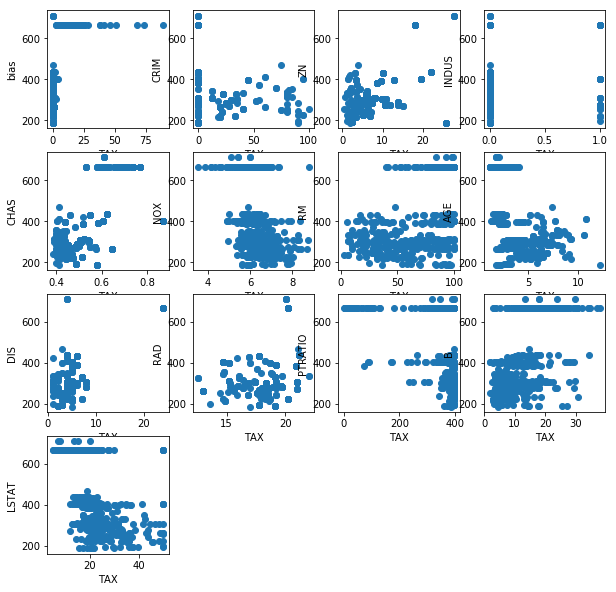

In [5]:
# Data same as A1
data = np.loadtxt("C:/Users/Yashad/Desktop/Books/machine learning/housing.data")

names =  ['CRIM','ZN','INDUS','CHAS','NOX',
          'RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']

#Separating TAX & storing in variable T
T = data[:, [9]] 
X = data[:, [0,1,2,3,4,5,6,7,8,10,11,12,13]] 

Xnames = ['CRIM','ZN','INDUS','CHAS', 'NOX',
          'RM','AGE','DIS','RAD','PTRATIO','B','LSTAT','MEDV']  
Tname = names[9] # Assigning TAX to Tname
Xnames.insert(0, 'bias') # adding bias column(ones) 

#Plotting tax with respect to other elements to check dependence
plt.figure(figsize=(10,10))
nrow,ncol = X.shape
for c in range(ncol):
    plt.subplot(4,4, c+1)
    plt.plot(X[:,c],T,'o')
    plt.ylabel(Xnames[c])
    plt.xlabel(Tname)

## Results

[[   0.            0.           56.0118044    48.67039804   55.56954182]
 [   1.            0.           55.88885121   48.67039804   55.56954182]
 [   2.            0.           54.7192637    48.67039804   55.56954182]
 ..., 
 [ 207.            0.           52.01824197   34.88394487   34.88394487]
 [ 208.            0.           52.01824197   34.88394487   34.88394487]
 [ 209.            0.           52.01824197   34.88394487   34.88394487]]


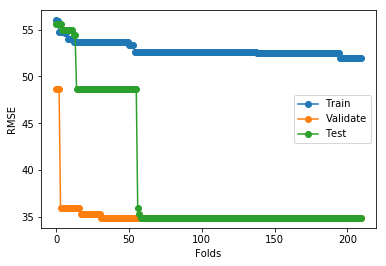

In [6]:
# Plotting result
results = multipleLambdas(X,T,15,range(0,40,5))
print(results)


plt.plot(results[:,0],results[:,2:],'o-')
plt.xlabel('Folds')
plt.ylabel('RMSE')
plt.legend(('Train','Validate','Test'),loc='best');

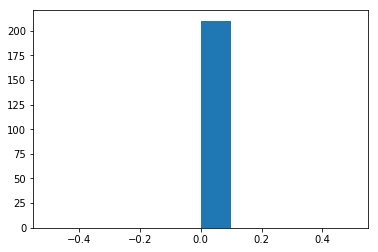

In [7]:
plt.hist(results[:,1]);

## Grading

Your notebook will be run and graded automatically.  After running all of the above cells in your notebook, run the code in the following cell to demonstrate an example grading session.  You should see a perfect score of 80/100 if your functions are defined correctly.  The remaining 20% will be based on the instructors reading of your notebooks.  We will be looking for how well the method is explained in text with some LaTeX math, and how well the results are summarized.

As before, first download and extract from [A2grader.tar](http://www.cs.colostate.edu/~anderson/cs
480/notebooks/A2grader.tar) 

In [8]:
%run -i "A2grader.py"

 Testing:
X = np.arange(20).reshape((-1,1))
T = np.abs(X -10) + X
for Xtrain,Ttrain,Xval,Tval,Xtest,Ttest,_ in partitionKFolds(X,T,5,shuffle=False,nPartitions=3)
20/20 points. partitionKFolds produced 20 partitions. Correct.
10/10 points. Final training set contains 12 samples. Correct.
10/10 points. Final validation set contains 4 samples. Correct.
Testing:
X = np.linspace(0,100,1000).reshape((-1,1))
T = X * 0.1
results = multipleLambdas(X,T,4,range(0,10))
20/20 points. All best lambdas are 0.  Correct.
20/20 points. Mean of all train, validation and test errors for best lambda are correct.

C:\Users\Yashad\Desktop\Books\machine learning Grade is 80/100
Up to 20 more points will be given based on the qualty of your descriptions of the method and the results.


## Check-in

Do not include this section in your notebook.

Name your notebook ```Lastname-A2.ipynb```.  So, for me it would be ```Anderson-A2.ipynb```.  Submit the file using the ```Assignment 2``` link on [Canvas](https://colostate.instructure.com/courses/41327).

Grading will be based on 

  * correct behavior of the three functions listed above,
  * easy to understand plots in your notebook
  * readability of the notebook,
  * effort in making interesting observations, and in formatting your notebook.